In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv("../data/deponieanlieferungen-tufentobel.csv", delimiter=';')

#Check for missing values
missing_values = df.isna().sum()
missing_values

#missing values are in column "Kanton" with only 94 values missing
#also, the there are no relevant outliers in these 94 values
df[df['Kanton'].isna()].describe()

#drop missing values for Kanton
df.dropna(subset=['Kanton'], inplace=True)

#check where the anlieferungen are zero tons
df[df['Gewicht in Tonnen'] == 0].value_counts().sum()

#remove these values
df.drop(df[df['Gewicht in Tonnen'] == 0].index, inplace=True)

#test if it worked
df[df['Gewicht in Tonnen'] == 0].value_counts().sum()

#check very small values
#print(df[df['Gewicht in Tonnen'] < 0.1].value_counts().sum())

#check duplicates
duplicates = df.duplicated()
#print(f"Number of duplicate rows: {duplicates.sum()}")

# #Visualize the outliers in a plot
# plt.figure(figsize=(10, 6))
# plt.boxplot(df['Gewicht in Tonnen'], vert=False)
# plt.title('Boxplot of Gewicht in Tonnen')
# plt.xlabel('Gewicht in Tonnen')
# plt.show()

# df[df['Gewicht in Tonnen'] > 35]

#there is one outlier with 56.7 tons, the other values dont go over 35 tons
#remove this outlier
df.drop(df[df['Gewicht in Tonnen'] > 50].index, inplace=True)

#Time series decomposition

# Convert the date column to datetime
df['Anlieferungsdatum'] = pd.to_datetime(df['Anlieferungsdatum'], utc=True)

# # Set the date column as the index
df.set_index('Anlieferungsdatum', inplace=True)

In [3]:
# intepolate missing values
daily_data = df['Gewicht in Tonnen'].resample('D').sum()
daily_data.replace(0, np.nan, inplace=True)
daily_data = daily_data.interpolate(method='time')

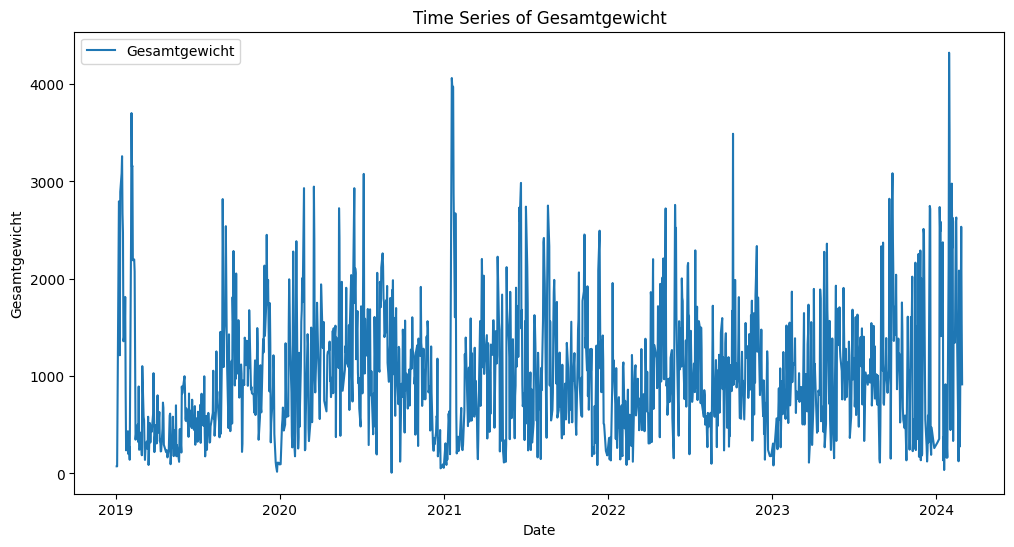

In [4]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data, label='Gesamtgewicht')
plt.title('Time Series of Gesamtgewicht')
plt.xlabel('Date')
plt.ylabel('Gesamtgewicht')
plt.legend()
plt.show()

In [5]:
# Write the daily_data series to a CSV file
daily_data.to_csv('daily_data.csv', header=True)

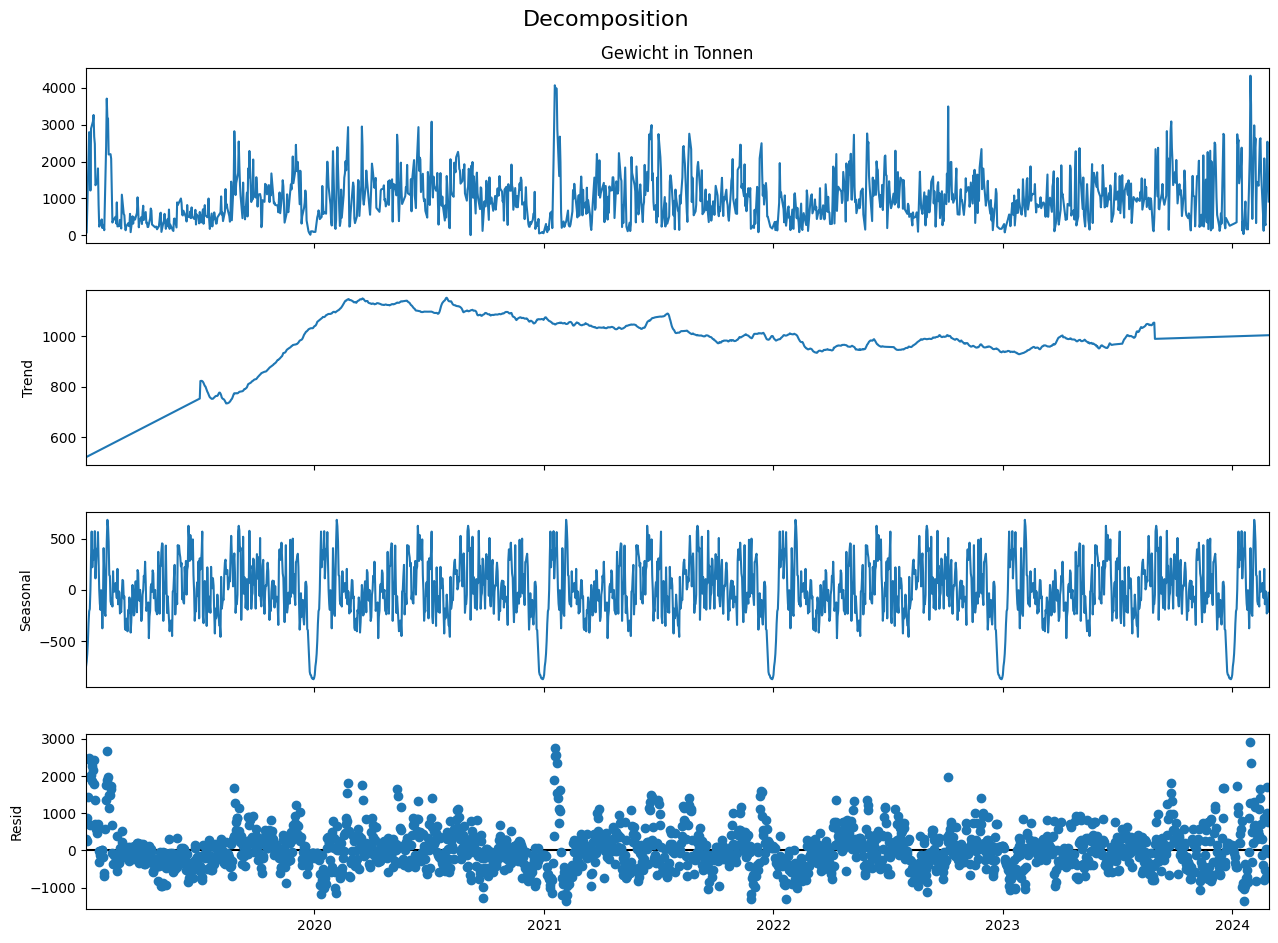

In [6]:

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data, model='additive', period=365, extrapolate_trend='freq')

# Plot the decomposition
# Extract trend and seasonal components
trend = decomposition.trend
seasonal = decomposition.seasonal

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Decomposition', fontsize=16)
plt.show()

In [7]:
# Append the trend, seasonal, and residual components to the daily_data dataframe
daily_data_df = daily_data.to_frame(name='Gesamtgewicht')
daily_data_df['Trend'] = decomposition.trend
daily_data_df['Seasonal'] = decomposition.seasonal
daily_data_df['Residual'] = decomposition.resid

# Export the dataframe to a CSV file
daily_data_df.to_csv('daily_data_with_decomposition.csv', header=True)

Decomposition

In [16]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(daily_data)

# Extract and print the test statistic and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print("Critical Values:", adf_result[4])

ADF Statistic: -11.740883918111322
p-value: 1.2745481229664193e-21
Critical Values: {'1%': -3.433842413401391, '5%': -2.8630827037453277, '10%': -2.5675912790044446}


The ADF Statistic 
−6.1059 is more negative than the critical values at all levels (1%, 5%, 10%).
The p-value is much smaller than 
0.05, providing strong evidence to reject the null hypothesis.
Conclusion:
The time series is stationary at all commonly used significance levels.

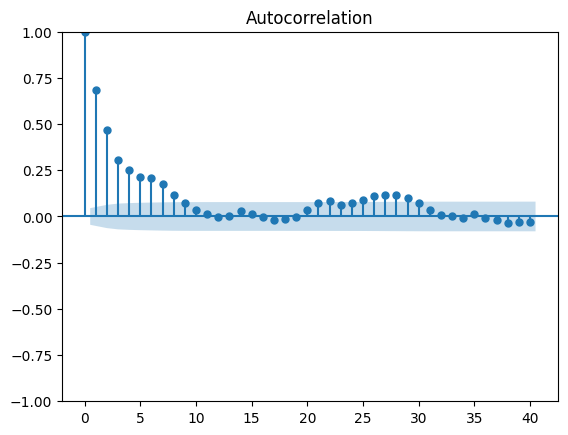

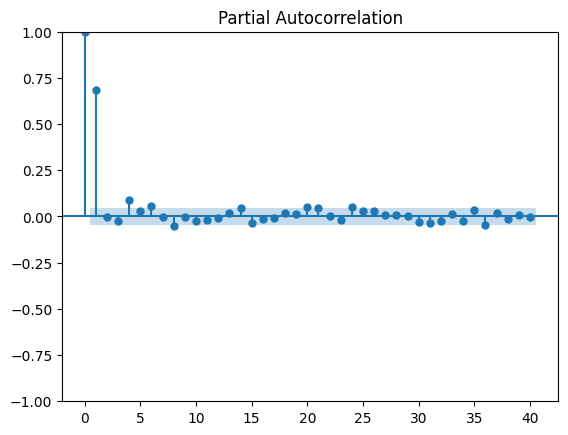

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(daily_data, lags=40)
plot_pacf(daily_data, lags=40)
plt.show()

/Users/carlernstmueller/.pyenv/versions/project_13/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/carlernstmueller/.pyenv/versions/project_13/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/carlernstmueller/.pyenv/versions/project_13/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/carlernstmueller/.pyenv/versions/project_13/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible st

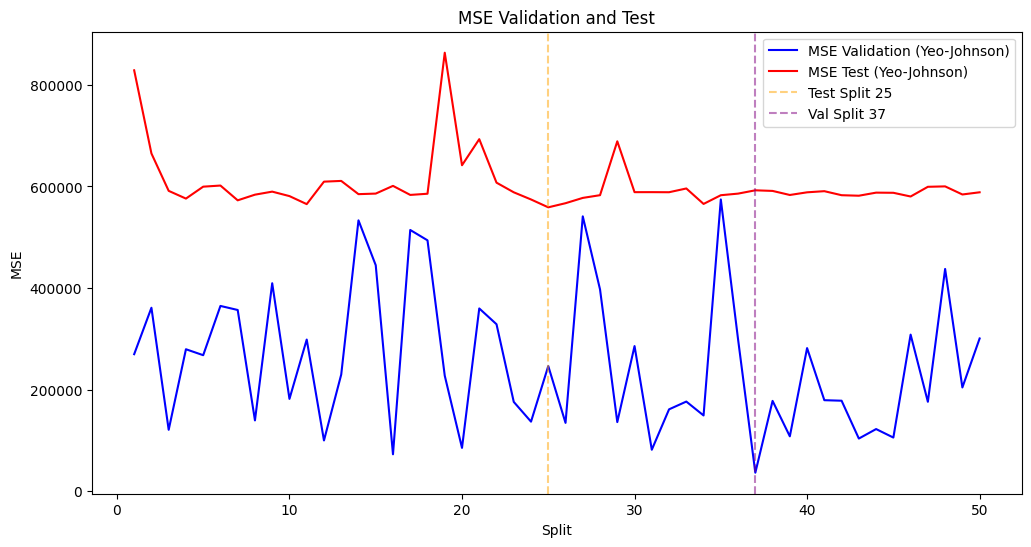

In [19]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np

# --- Define ARIMA parameters ---
p, d, q = 2, 1, 1

# --- 4. Data Splitting ---
test_size = 100  # Size of the independent test set
validate_size = 20  # Size of each validation split
train_validate_size = len(daily_data) - test_size  # Remaining data for training and validation

# Split data
train_validate_data = daily_data[:train_validate_size]
test_data = daily_data[train_validate_size:]

# --- 5. Rolling Validation ---
n_splits = 50
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=validate_size)

# Yeo-Johnson Transformer
yeo_transformer = PowerTransformer(method='yeo-johnson', standardize=False)

# Error lists
validate_errors = []
standardized_validate_errors = []
standardized_test_errors = []

# --- TESTING ---
# Detrend and deseasonalize
test_residual = test_data
# Yeo-Johnson transformation
test_transformed = yeo_transformer.fit_transform(test_residual.values.reshape(-1, 1)).flatten()

# --- 6. Training and Validation ---
plt.figure(figsize=(12, 6))

for i, (train_index, validate_index) in enumerate(tscv.split(train_validate_data)):
    # Create train and validation splits
    train, validate = train_validate_data.iloc[train_index], train_validate_data.iloc[validate_index]
    # trend_train, trend_validate = trend_train_validate.iloc[train_index], trend_train_validate.iloc[validate_index]
    # seasonal_train, seasonal_validate = seasonal_train_validate.iloc[train_index], seasonal_train_validate.iloc[validate_index]
    
    # TRAINING
    # Detrend and deseasonalize
    train_residual = train # - trend_train - seasonal_train
    # Yeo-Johnson transformation
    train_transformed = yeo_transformer.fit_transform(train_residual.values.reshape(-1, 1)).flatten()
    
    # VALIDATION
    # Detrend and deseasonalize
    validate_residual = validate # - trend_validate - seasonal_validate
    # Transform using parameters learned from training
    validate_transformed = yeo_transformer.transform(validate_residual.values.reshape(-1, 1)).flatten()

    # Fit ARIMA model on training split
    model = ARIMA(train_transformed, order=(p, d, q))
    model_fit = model.fit()
    
    # Forecast on validation split
    forecast_transformed = model_fit.forecast(steps=len(validate_transformed))

    # Standardized validation error
    standardized_error = mean_squared_error(validate_transformed, forecast_transformed)
    standardized_validate_errors.append(standardized_error)

    # TEST
    # Forecast on test split
    forecast_test_transformed = model_fit.forecast(steps=len(test_transformed))

    # Standardized test error
    test_error = mean_squared_error(test_transformed, forecast_test_transformed)
    standardized_test_errors.append(test_error)

# --- 8. Plot Results ---
# Moving average for validation errors
plt.plot(range(1, n_splits + 1), standardized_validate_errors, label="MSE Validation (Yeo-Johnson)", color='blue')
plt.plot(range(1, n_splits + 1), standardized_test_errors, label="MSE Test (Yeo-Johnson)", color='red')

# Find the split with the lowest standardized test error
min_error_index = standardized_test_errors.index(min(standardized_test_errors)) + 1
min_error_value = min(standardized_test_errors)
min_valerror_index = standardized_validate_errors.index(min(standardized_validate_errors)) + 1
min_valerror_value = min(standardized_validate_errors)

# Plot vertical and horizontal lines at the minimum error
plt.axvline(x=min_error_index, color='orange', alpha=0.5, linestyle='--', label=f'Test Split {min_error_index}')
plt.axvline(x=min_valerror_index, color='purple', alpha=0.5, linestyle='--', label=f'Val Split {min_valerror_index}')

plt.title("MSE Validation and Test")
plt.xlabel("Split")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [20]:
print('x1:',list(range(1, n_splits + 1)))
print('y1:', standardized_validate_errors)
print('y2:', standardized_test_errors)

x1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
y1: [269736.76521150244, 361154.9699723843, 120864.68378131647, 279494.275869437, 267763.52600911394, 364734.8790368285, 356757.3587207499, 139406.15976124528, 409401.7419848654, 181736.13144833242, 298549.3334044533, 99906.01121390541, 229697.24112289902, 533235.5049068504, 444862.4801776864, 72679.13769657197, 514275.9208357212, 493902.6184328493, 227431.2852265443, 85258.079370903, 359782.01992190455, 328705.58137739386, 175809.03828790836, 136939.0383027668, 246386.02675366303, 134495.4466996538, 541068.9114211481, 397157.0442211234, 136020.53708008752, 285738.91195191175, 81628.80136348859, 161171.5818123268, 176474.9530395761, 149123.53117515848, 574342.8011264756, 298858.7117123435, 36393.42790661891, 177803.35042198398, 108039.73720177278, 281739.60962403246, 179174.79674992207, 178156